In [1]:
import logging
import asyncio
import uuid
import os
from typing import Annotated, TypedDict, List, Dict, Any, Optional
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph, START
from pydantic import BaseModel, Field
from dotenv import load_dotenv
import gradio as gr
from IPython.display import Image, display
from datetime import datetime
import json

c:\Users\DeepDabhi\Desktop\Projects\travel-track\travel-serp-new\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SmartJSONFormatter(logging.Formatter):
    def format(self, record):
        base = f"{self.formatTime(record)} - {record.name} - {record.levelname}"
        msg = record.msg
        try:
            if isinstance(msg, dict):
                return f"{base} - JSON payload:\n{json.dumps(msg, indent=2, default=str)}"
            if isinstance(msg, str) and msg.strip().startswith(("{", "[")):
                parsed = json.loads(msg)
                return f"{base} - JSON payload:\n{json.dumps(parsed, indent=2, default=str)}"
        except Exception as e:
            logger.warning(f"Failed to serialize log message as JSON: {e}")
        return f"{base} - {record.getMessage()}"


# Configure logging with File + Console
logging.basicConfig(
    level=logging.INFO,
    handlers=[
        logging.FileHandler("clean_4.log"),
        logging.StreamHandler()
    ]
)

# Apply formatter to all handlers
formatter = SmartJSONFormatter()
for handler in logging.getLogger().handlers:
    handler.setFormatter(formatter)

logger = logging.getLogger(__name__)


In [3]:
now = datetime.now()
current_date = now.date()
current_day = now.strftime("%A")

In [4]:
# Load environment variables
logger.info("Loading environment variables")
load_dotenv(override=True)

2025-08-25 15:55:33,946 - __main__ - INFO - Loading environment variables


True

In [5]:
# loading APIs
google_api_key = os.getenv("GOOGLE_API_KEY")
if not google_api_key:
    raise ValueError("GOOGLE_API_KEY not found in .env file")

In [6]:
try:
    llm_1 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_2 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
    llm_3 = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)
except Exception as e:
    logger.error(f"Failed to initialize LLMs: {str(e)}")
    raise

In [7]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feddback on assistant's response")
    success_criteria_met: bool = Field(description="wether the success criteria have been met or not")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [8]:
class PayloadOutput(BaseModel):
    departure_city: str = Field(description="The departure city")
    arrival_city: str = Field(description="The arrival city")
    outbound_date: str = Field(description="The departure date")
    adults: int = Field(description="Number of adults", default=0)
    children: int = Field(description="Number of children", default=0)
    travel_class: str = Field(description="Travel class: Economy, Premium economy, Business, First.", default="Economy")
    return_date: Optional[str] = Field(description="Return date in format YYYY-MM-DD (e.g., 2025-08-17)", default=None)

In [9]:
FIXED_SUCCESS_CRITERIA = (
    "The assistant must obtain and confirm the following required flight details: departure city, arrival city, departure date, number of adults, number of children."
    "Optional detail for flight booking is return date"
)

In [10]:
class State(BaseModel):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str = FIXED_SUCCESS_CRITERIA
    feedback: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool
    # iteration_count: int
    collected_details: PayloadOutput

In [11]:
worker_llm = llm_1
evaluator_llm = llm_2
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)
payload_llm = llm_3.with_structured_output(PayloadOutput)

In [12]:
def worker(state: State) -> Dict[str, Any]:
    logger.info("Entering worker node")
    logger.info(state.model_dump())
    logger.info("Input state messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})

    system_message = f"""
        You are a helpful travel assistant responsible for extracting and validating flight booking details.
        
        You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
        This is the success criteria:
        {state.success_criteria}
        
        flight booking details for payload generation are of two types: *required fields*, *optional fields*
        
        required_fields: [Departure city, Arrival city, Outbound date, Number of adults, Number of children, Travel class]
        optional_fields: [Return date]
        
        Today's date is {current_day}, {current_date}.
        Follow this structured process:

        1. **Required details for payload generation (must collect before proceeding)**
            you are collecting values for required_fields
            - Departure city (name of the city user is departing from)
            - Arrival city (name of the city user is arriving to)
            - Outbound date (YYYY-MM-DD format)
            - Number of adults (18+ years)
            - Number of children (below 18 years)
            - Travel class (Economy, Premium Economy, Business, First Class)
        
        2. **Optional Details (ask only after required details are complete):**
            you are collecting values for optional_fields
            do not specifically ask each of the fields, generally ask if you want any more specifications? then populate the optional fields based on the user query, if user is specifying requirements for the fields that are not amongst optional fields, then tell user that you are not able to fulfill that requirements:
        - Return date (YYYY-MM-DD format)
        
        3. **Rules**
        (A) Rules for collecting fields
        - Departure city: Name of the city user is departing from
        - Arrival city: Name of the city user is going to
        - Outbound date: If the user provides relative or ambiguous dates (e.g., "next Monday", "on my birthday", "my marriage anniversary"), ask for clarification or parse using today's date: {current_date} and current day: {current_day} as reference. If the user provides a specific date (e.g., "2004-08-31"), verify that it is in the future (after {current_date}). If the date is in the past, ask the user to confirm if they meant a future date (e.g., the next occurrence of the same day/month, such as 2025-08-31 for an anniversary date of 2004-08-31). Collected dates must be in YYYY-MM-DD format and represent a future date.
        - Number of adults: When the user mentions multiple travelers (e.g., "me, my wife, and son"), confirm the age of each individual explicitly to determine the number of adults (18+ years). Do not assume ages based on relationships (e.g., "me," "wife," "son").
        - Number of children: When the user mentions multiple travelers (e.g., "me, my wife, and son"), confirm the age of each individual explicitly to determine the number of children (below 18 years). Do not assume ages based on relationships.
        - Travel class: Travel class should be one of the value of list: [Economy, Premium Economy, Business, First Class]

        (B) Asking for follow ups on refusal
        - If the user refuses to provide a required field, politely explain it is necessary and ask again.
        
        (C) When to respond
        - Do not generate a confirmation message until all required details are collected following the rules for collecting fields.

        4. **Response Format:**
        - If details are missing: "Question: [your question]"
        - If a required field is refused: "I'm sorry, but [field] is required to proceed. Please provide [field]."
        - If all details are collected respond with: "Here are the flight details: Departure from [Departure city], Arrival at [Arrival city], on [Outbound date], with [X adults] and [Y children], Travel class: [Travel class]. Would you like to proceed with the booking?"
    """

    if state.feedback:
        logger.info("Incorporating feedback:")
        logger.info(state.feedback)
        system_message += f"""
    Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
    Here is the feedback on why this was rejected:
    {state.feedback}
    With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
        
    found_system_message = False
    messages = state.messages
    logger.info("Processing messages: ")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})

    for message in messages:
        if isinstance(message, SystemMessage):
            logger.info("Updating existing system message")
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        logger.info("Adding new system message")
        messages = [SystemMessage(content=system_message)] + messages
    
    logger.info("Messages after system message handling: ")
    logger.info({"messages": [msg.model_dump() for msg in messages]}) 

    logger.info("Invoking worker LLM")
    response = worker_llm.invoke(messages)
    
    logger.info("Worker LLM response:")
    logger.info(str(response))
    
    logger.info("Adding worker response to state messages")
    new_state = {
        "messages": [response]
    }
    
    logger.info("Output state messages: ")
    logger.info({"messages": [msg.model_dump() for msg in new_state['messages']]})
    
    return new_state

In [13]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[No content]"
            conversation += f"Assistant: {text}\n"
        elif isinstance(message, SystemMessage):
            conversation += f"System: {message.content}\n"
    return conversation

In [14]:
def evaluator(state: State) -> State:
    logger.info(f"\nEntering evaluator node")
    logger.info(state)
    last_response = state.messages[-1].content
    logger.info(f"Evaluating last response:")
    logger.info({last_response})
    logger.info(f"Current state messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})
    
    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
    Assess of the Assistant last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
    and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

    The entire conversation with the assistant, with the original request of the user and all replies, are:
    {format_conversation(state.messages)}

    The success criteria for this assignment is:
    {state.success_criteria}

    And the final response from the Assistant that you are evaluating is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    if state.feedback:
        logger.info("Adding previous feedback to evaluation:")
        logger.info(state.feedback)
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state.feedback}\n"
        user_message += "If you are seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    logger.info("Evaluator input messages:")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})
    
    logger.info("Invoking evaluator LLM")
    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    logger.info(f"Evaluator result: feedback={eval_result.feedback}, success_criteria_met={eval_result.success_criteria_met}, user_input_needed={eval_result.user_input_needed}")
    
    new_state = State(
        messages=[AIMessage(content=f"Evaluator Feedback on this answer: {eval_result.feedback}")],
        success_criteria=state.success_criteria,
        feedback=eval_result.feedback,
        success_criteria_met=eval_result.success_criteria_met,
        user_input_needed=eval_result.user_input_needed,
        collected_details=state.collected_details
    )
    
    logger.info("Adding evaluator feedback to state messages")
    logger.info(f"New state: ")
    logger.info(new_state.model_dump())
    return new_state

In [15]:
def create_payload(state: State) -> Dict[str, Any]:
    logger.info("Entering payload generator node")
    logger.info({"state": state.model_dump()})
    
    # Extract the latest assistant message
    messages = state.messages
    latest_message = None
    for message in reversed(messages):
        if isinstance(message, AIMessage):
            latest_message = message.content
            break
    
    if not latest_message:
        logger.error("No assistant message found in state")
        return {
            "messages": [AIMessage(content="Error: Unable to generate payload due to missing assistant response.")],
            "user_input_needed": True
        }
    
    logger.info(f"Processing latest assistant message: {latest_message}")
    
    # Check if the message indicates all required details are collected
    # if "Here are the flight details" in latest_message:
    try:
        # Invoke payload_llm to generate structured output
        logger.info("Invoking payload LLM")
        payload = payload_llm.invoke(messages)
        
        logger.info("Generated payload:")
        logger.info(json.dumps(payload.model_dump(), indent=2))

        new_state = State(
            messages=[AIMessage(content=f"Payload generated successfully: {json.dumps(payload.model_dump(), indent=2)}")],
            success_criteria=state.success_criteria,
            feedback=state.feedback,
            success_criteria_met=state.success_criteria_met,
            user_input_needed=False,
            collected_details=payload  # Update this field
        )
        logger.info(new_state.model_dump())
        return new_state
    except Exception as e:
        logger.error(f"Error generating payload: {str(e)}")
        return {
            "messages": [AIMessage(content="Sorry, I encountered an error while generating the booking details. Could you please confirm the details again?")],
            "success_criteria_met": False,
            "user_input_needed": True
        }

In [16]:
def getAirports(location):
    return "TIR"

In [17]:
def getAirports(location):
    return "TIR"

In [18]:
def route_based_on_evaluation(state: State) -> str:
    if state.success_criteria_met:
        return "create_payload"
    if state.user_input_needed:
        return END
    logger.info("Routing to worker: Continuing extraction")
    return "worker"

In [19]:
logger.info("Setting up LangGraph")
graph_builder = StateGraph(State)

# Add nodes
logger.info("Adding nodes to graph")
graph_builder.add_node("worker", worker)
graph_builder.add_node("evaluator", evaluator)
graph_builder.add_node("create_payload", create_payload)

# Add edges
logger.info("Adding edges to graph")
graph_builder.add_edge("worker", "evaluator")
graph_builder.add_edge("create_payload", END)
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"create_payload": "create_payload", "worker": "worker", END: END})
graph_builder.add_edge(START, "worker")

# Compile the graph
logger.info("Compiling LangGraph with memory")
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

2025-08-25 15:55:34,909 - __main__ - INFO - Setting up LangGraph
2025-08-25 15:55:34,913 - __main__ - INFO - Adding nodes to graph
2025-08-25 15:55:34,920 - __main__ - INFO - Adding edges to graph
2025-08-25 15:55:34,953 - __main__ - INFO - Compiling LangGraph with memory


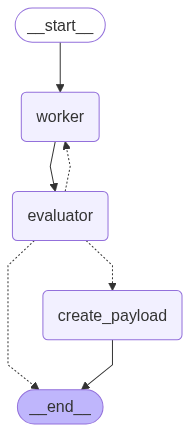

In [20]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    logger.warning(f"Failed to display graph: {str(e)}")

In [21]:
def make_thread_id() -> str:
    thread_id = str(uuid.uuid4())
    logger.info(f"Generated new thread ID: {thread_id}")
    return thread_id

async def process_message(message, history, thread):
    logger.info(f"Processing new user message: {message}")
    
    config = {"configurable": {"thread_id": thread}}
    
    state = State(
        messages=[HumanMessage(content=message)],
        success_criteria=FIXED_SUCCESS_CRITERIA,
        feedback=None,
        success_criteria_met=False,
        user_input_needed=False,
        collected_details = PayloadOutput(
            departure_city="",
            arrival_city="",
            outbound_date="",
            travel_class="Economy",
            adults=0,
            children=0,
            return_date=None
        )
    )
    logger.info("Initial state created")
    logger.info(f"Initial state messages: ")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})    

    logger.info("Invoking graph with initial state")
    result = await graph.ainvoke(state, config=config)
    logger.info("Graph invocation completed")
    logger.info(f"Graph result messages: ")
    logger.info({"messages": [msg.model_dump() for msg in state.messages]})
    
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    
    logger.info("Preparing response for Gradio UI")
    logger.info(f"User message:")
    logger.info(user)
    logger.info(f"Assistant reply: ")
    logger.info(reply)
    logger.info(f"Evaluator feedback:")
    logger.info(feedback)
    
    logger.info("Message processing completed")
    return history + [user, reply, feedback]

In [22]:
async def reset():
    logger.info("Resetting application state")
    return "", None, make_thread_id()

In [23]:
logger.info("Launching Gradio UI")
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        # chatbot = current state of the chatbot component (conversation history)
        chatbot = gr.Chatbot(label="Travel Chatbot", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    
    logger.info("Setting up Gradio event handlers")
    message.submit(process_message, [message, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, chatbot, thread])

2025-08-25 15:55:37,076 - __main__ - INFO - Launching Gradio UI
2025-08-25 15:55:37,575 - __main__ - INFO - Generated new thread ID: fc70fd63-8dd8-48fe-86e6-dbc51b4755aa
2025-08-25 15:55:37,595 - __main__ - INFO - Setting up Gradio event handlers


2025-08-25 15:55:40,949 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


In [ ]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7860


2025-08-25 15:55:41,237 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-08-25 15:55:41,446 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"


* To create a public link, set `share=True` in `launch()`.


2025-08-25 15:56:00,107 - __main__ - INFO - Processing new user message: hi
2025-08-25 15:56:00,120 - __main__ - INFO - Initial state created
2025-08-25 15:56:00,123 - __main__ - INFO - Initial state messages: 
2025-08-25 15:56:00,127 - __main__ - INFO - JSON payload:
{
  "messages": [
    {
      "content": "hi",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": null,
      "id": null,
      "example": false
    }
  ]
}
2025-08-25 15:56:00,132 - __main__ - INFO - Invoking graph with initial state
2025-08-25 15:56:00,266 - __main__ - INFO - Entering worker node
2025-08-25 15:56:00,297 - __main__ - INFO - JSON payload:
{
  "messages": [
    {
      "content": "hi",
      "additional_kwargs": {},
      "response_metadata": {},
      "type": "human",
      "name": null,
      "id": "38fe8688-a873-45c5-8904-fdfe5534a7db",
      "example": false
    }
  ],
  "success_criteria": "The assistant must obtain and confirm the following required fli